# Library

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Datasets

In [ ]:
filepath = '/content/Sunspots.csv'
data = pd.read_csv(filepath, usecols=['Date','Monthly Mean Total Sunspot Number'])
data.dropna(inplace=True)
print(len(data))

3240


In [ ]:
data.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [ ]:
time_data = data['Date'].to_numpy()
series = data['Monthly Mean Total Sunspot Number'].to_numpy()

In [ ]:
len(time_data)

3240

In [ ]:
test_df = data[(data['Date'] > '2018-08-01') & (data['Date'] <= '2018-12-31')]

In [ ]:
test_df.tail()

,Date,Monthly Mean Total Sunspot Number
3235,2018-08-31,8.7
3236,2018-09-30,3.3
3237,2018-10-31,4.9
3238,2018-11-30,4.9
3239,2018-12-31,3.1


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.title('Forecasting trend')
    plt.xlabel('Date')
    plt.ylabel('Monthly Mean Total Sunspot Number')
    plt.grid(True)

# Model

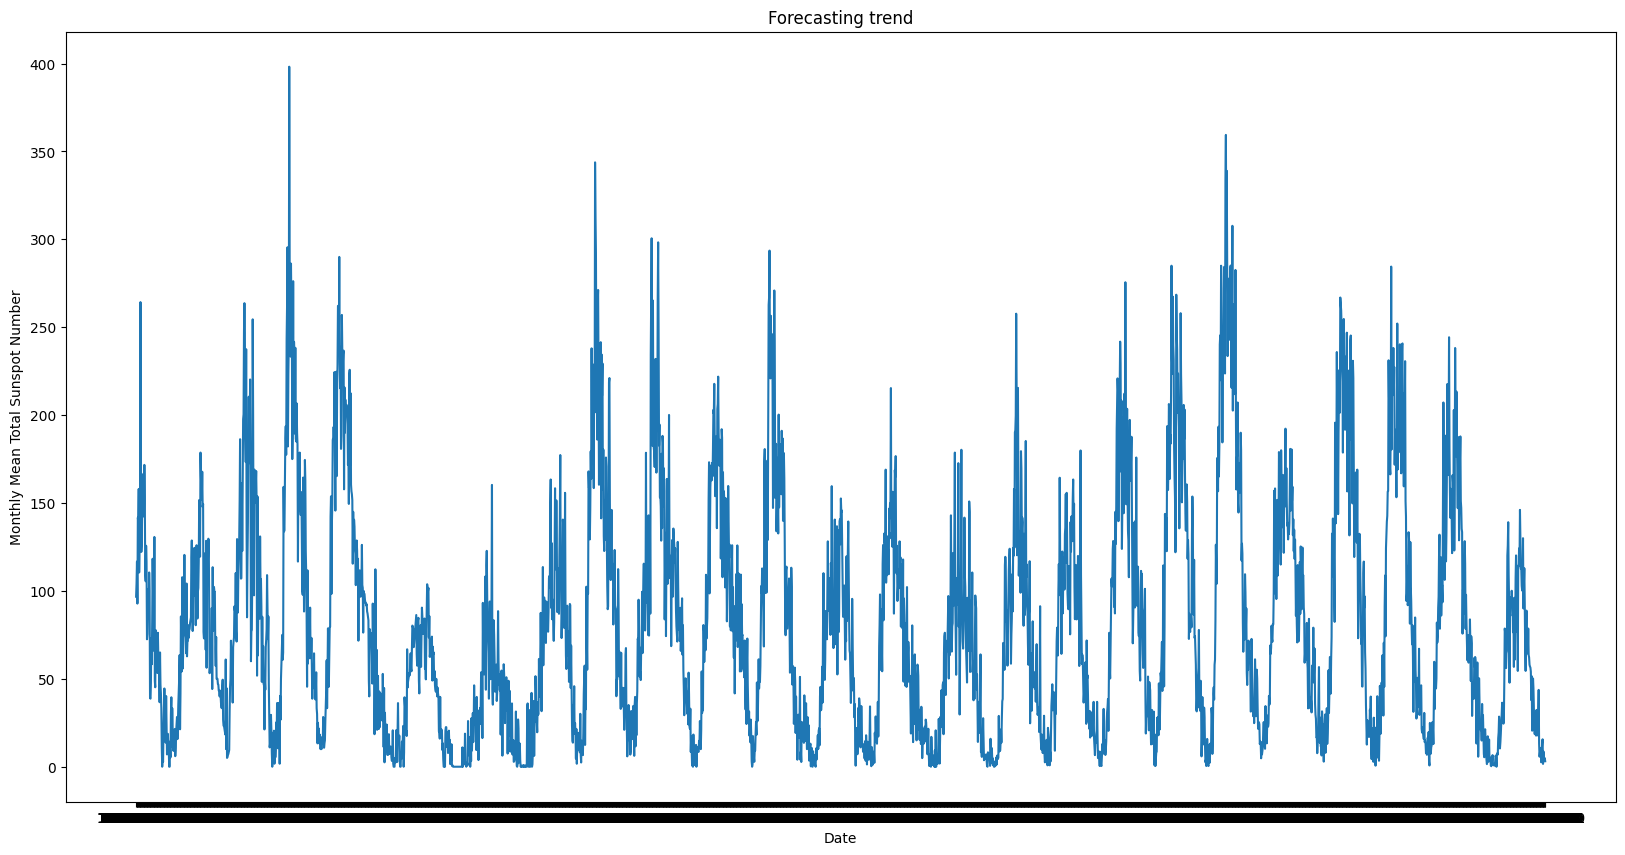

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Forecasting trend')
plt.xlabel('Date')
plt.ylabel('Monthly Mean Total Sunspot Number')

plt.plot(data['Date'], data['Monthly Mean Total Sunspot Number'])
plt.show()

# Hyper Paramater (Tuning)

In [ ]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Split Dataset into Training and Validation

In [ ]:
split = 3000
training = time_data[:split]
x_training = series[:split]
validation = time_data[split:]
x_validation = series[split:]

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:

dataset = windowed_dataset(x_training, window_size, batch_size, shuffle_buffer_size)
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9), metrics=["mae"])

In [ ]:
history = model.fit(dataset,epochs=100)

Epoch 1/100
93/93 [==============================] - 1s 9ms/step - loss: 16.6717 - mae: 17.1634
Epoch 2/100
93/93 [==============================] - 1s 12ms/step - loss: 16.6709 - mae: 17.1616
Epoch 3/100
93/93 [==============================] - 2s 12ms/step - loss: 16.7256 - mae: 17.2169
Epoch 4/100
93/93 [==============================] - 2s 17ms/step - loss: 16.5950 - mae: 17.0862
Epoch 5/100
93/93 [==============================] - 1s 11ms/step - loss: 16.6366 - mae: 17.1275
Epoch 6/100
93/93 [==============================] - 1s 5ms/step - loss: 16.5912 - mae: 17.0816
Epoch 7/100
93/93 [==============================] - 1s 5ms/step - loss: 16.7476 - mae: 17.2378
Epoch 8/100
93/93 [==============================] - 1s 6ms/step - loss: 16.5423 - mae: 17.0335
Epoch 9/100
93/93 [==============================] - 1s 5ms/step - loss: 16.5132 - mae: 17.0031
Epoch 10/100
93/93 [==============================] - 1s 5ms/step - loss: 16.5391 - mae: 17.0295
Epoch 11/100
93/93 [===============

<Figure size 640x480 with 0 Axes>

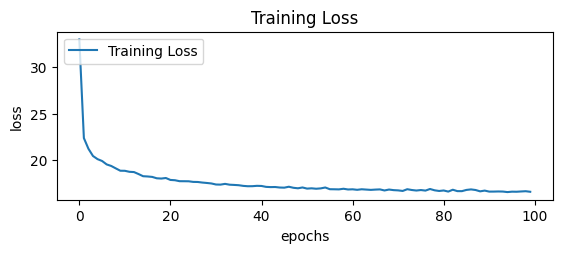

<Figure size 640x480 with 0 Axes>

In [ ]:
loss = history.history['loss']


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.title('Training Loss')

plt.figure()

# Predict the Model

In [ ]:
%time
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split-window_size:]
results = np.array(forecast)[:, 0, 0]


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs
1/1 [==============================] - 0s 38ms/step


KeyboardInterrupt: ignored

# Plot the Model Prediction

In [ ]:
plt.figure(figsize=(20, 10))
start_index = len(validation) - len(test_df)
end_index = len(validation)

plot_series(validation[start_index:end_index], x_validation[start_index:end_index])
plot_series(validation[start_index:end_index], results[start_index:end_index])

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Sunspot Forecast')
plt.legend(['Actual Data', 'Predictions'])
plt.xticks(rotation=45)
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(series) - split), results, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Predicted Values')
plt.legend()
plt.show()

In [ ]:
year_to_plot = 2019
start_year = 2019
num_data_points_per_year = 24

start_index = (year_to_plot - start_year) * num_data_points_per_year
end_index = start_index + num_data_points_per_year

predicted_year = results[start_index:end_index]

dates = pd.date_range(start=str(year_to_plot), periods=num_data_points_per_year, freq='M')

plt.figure(figsize=(20, 6))
plt.plot(dates, predicted_year, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sunspot Value')
plt.title('Predicted Sunspot Values for ' + str(year_to_plot) + ' to ' + str(year_to_plot + 1))
plt.legend()
plt.show()

In [ ]:
import csv

with open('predictions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Date', 'Prediction'])
  
    for date, prediction in zip(dates, results):
        formatted_date = date.strftime('%Y-%m-%d')
        
        writer.writerow([formatted_date, prediction])
        
print("CSV file 'predictions.csv' has been created successfully.")


In [ ]:
print(forecast)